In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from __future__ import print_function
import argparse
import csv
import os.path
import torch.nn.parallel
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as datasets
import torchvision.models as models
from PIL import Image
import PIL
from torchsummary import summary
import functools

batch_size = 32

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
        if hasattr(m.bias, 'data'):
            m.bias.data.fill_(0)
    elif classname.find('BatchNorm2d') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


def get_norm_layer(norm_type='instance'):
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True)
    elif norm_type == 'instance':
        norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=True)
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
    return norm_layer


def define_G(input_nc=3, output_nc=3, ngf=64, norm='batch', use_dropout=False, gpu_ids=[], use_parallel=True,
             learn_residual=False):
    netG = None
    use_gpu = len(gpu_ids) > 0
    norm_layer = get_norm_layer(norm_type=norm)

    if use_gpu:
        assert (torch.cuda.is_available())


    netG = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=9,
                            gpu_ids=gpu_ids, use_parallel=use_parallel, learn_residual=learn_residual)


    if len(gpu_ids) > 0:
        netG.cuda(gpu_ids[0])
    netG.apply(weights_init)
    return netG


def define_D(input_nc=3, ndf=64, n_layers_D=3, norm='batch', use_sigmoid=True, gpu_ids=[],
             use_parallel=True):
    netD = None
    use_gpu = len(gpu_ids) > 0
    norm_layer = get_norm_layer(norm_type=norm)

    if use_gpu:
        assert (torch.cuda.is_available())


    netD = NLayerDiscriminator(input_nc, ndf, n_layers_D, norm_layer=norm_layer, use_sigmoid=use_sigmoid, gpu_ids=gpu_ids, use_parallel=use_parallel)

    if use_gpu:
        netD.cuda(gpu_ids[0])
    netD.apply(weights_init)
    return netD


def print_network(net):
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print(net)
    print('Total number of parameters: %d' % num_params)

class ResnetGenerator(nn.Module):
    def __init__(
            self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False,
            n_blocks=6, gpu_ids=[], use_parallel=True, learn_residual=False, padding_type='reflect'):
        assert (n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf
        self.gpu_ids = gpu_ids
        self.use_parallel = use_parallel
        self.learn_residual = learn_residual

        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
            norm_layer(ngf),
            nn.ReLU(True)
        ]

        n_downsampling = 2

        model += [
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=use_bias),
            norm_layer(128),
            nn.ReLU(True),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=use_bias),
            norm_layer(256),
            nn.ReLU(True)
        ]

        # mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [
                ResnetBlock(256, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)
            ]


        model += [
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=use_bias),
            norm_layer(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=use_bias),
            norm_layer(64),
            nn.ReLU(True),
        ]

        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_nc, kernel_size=7, padding=0),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        if self.gpu_ids and isinstance(input.data, torch.cuda.FloatTensor) and self.use_parallel:
            output = nn.parallel.data_parallel(self.model, input, self.gpu_ids)
        else:
            output = self.model(input)
        if self.learn_residual:
            # output = input + output
            output = torch.clamp(input + output, min=-1, max=1)
        return output


# Define a resnet block
class ResnetBlock(nn.Module):

	def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
		super(ResnetBlock, self).__init__()

		padAndConv = {
			'reflect': [
                nn.ReflectionPad2d(1),
                nn.Conv2d(dim, dim, kernel_size=3, bias=use_bias)],
			'replicate': [
                nn.ReplicationPad2d(1),
                nn.Conv2d(dim, dim, kernel_size=3, bias=use_bias)],
			'zero': [
                nn.Conv2d(dim, dim, kernel_size=3, padding=1, bias=use_bias)]
		}

		try:
			blocks = padAndConv[padding_type] + [
				norm_layer(dim),
				nn.ReLU(True)
            ] + [
				nn.Dropout(0.5)
			] if use_dropout else [] + padAndConv[padding_type] + [
				norm_layer(dim)
			]
		except:
			raise NotImplementedError('padding [%s] is not implemented' % padding_type)

		self.conv_block = nn.Sequential(*blocks)


	def forward(self, x):
		out = x + self.conv_block(x)
		return out



class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d, use_sigmoid=False, gpu_ids=[],
                 use_parallel=True):
        super(NLayerDiscriminator, self).__init__()
        self.gpu_ids = gpu_ids
        self.use_parallel = use_parallel

        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = int(np.ceil((kw - 1) / 2))
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
            nn.LeakyReLU(0.2, True)
        ]

        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                          kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]

        if use_sigmoid:
            sequence += [nn.Sigmoid()]

        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        if len(self.gpu_ids) and isinstance(input.data, torch.cuda.FloatTensor) and self.use_parallel:
            print(1)
            return nn.parallel.data_parallel(self.model, input, self.gpu_ids)
        else:
            print(2)
            return self.model(input)

In [ ]:
print_network(define_D(3,128))

NLayerDiscriminator(
  (model): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2), bias=False)
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (12): Sigmoid()
  )
)
Total number of parameters

In [ ]:
summary(define_D().cuda(), (3, 128, 128))

2
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 65, 65]           3,136
         LeakyReLU-2           [-1, 64, 65, 65]               0
            Conv2d-3          [-1, 128, 33, 33]         131,072
       BatchNorm2d-4          [-1, 128, 33, 33]             256
         LeakyReLU-5          [-1, 128, 33, 33]               0
            Conv2d-6          [-1, 256, 17, 17]         524,288
       BatchNorm2d-7          [-1, 256, 17, 17]             512
         LeakyReLU-8          [-1, 256, 17, 17]               0
            Conv2d-9          [-1, 512, 18, 18]       2,097,152
      BatchNorm2d-10          [-1, 512, 18, 18]           1,024
        LeakyReLU-11          [-1, 512, 18, 18]               0
           Conv2d-12            [-1, 1, 19, 19]           8,193
          Sigmoid-13            [-1, 1, 19, 19]               0
Total params: 2,765,633
Trainable par

In [ ]:
def is_image_file(filename): # 이미지 파일 로드 함수 오픈소스 사용
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg", ".gif"])

In [ ]:
class ImageDataset(Dataset): # 이미지 파일 로드 함수 오픈소스 사용

  def __init__(self, image_dir, input_transforms=None):
      super(ImageDataset, self).__init__()
      self.image_filenames = [os.path.join(image_dir, x) for x in os.listdir(image_dir) if is_image_file(x)]
      self.input_transforms = input_transforms

  def __getitem__(self, index):
      input = Image.open(self.image_filenames[index])

      if self.input_transforms:
        input = self.input_transforms(input)
      
      return input
  
  def __len__(self):
      return len(self.image_filenames)

In [ ]:
trans = transforms.Compose([
                            transforms.Resize((128,128)),
                            transforms.ToTensor(),
                            ]) # 이미지 128 x 128 사이즈 변경, tensor 로 변환


device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # gpu 사용 가능하면 gpu 사용

train_dir = '/content/drive/MyDrive/tst/seg_pred/seg_pred' #trainset 경로
# test_dir =  '/content/drive/MyDrive/tst/seg_train/seg_train/forest' #testset 경로 아직 미사용

train_dataset = ImageDataset(train_dir, input_transforms=trans) # trainset 로드후 텐서 변환

print(len(train_dataset)) #trainset 개수 출력

training_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size) # trainset batch_size 설정후 모델에 올릴수 있는 형태로 변환 DataLoader pytorch 자체 함수

Discri = define_D().cuda() if torch.cuda.is_available() else Discriminator()
# Discri.apply(weights_init)
Gener = define_G().cuda() if torch.cuda.is_available() else Generator()
# Gener.apply(weights_init)

Loss= nn.L1Loss().cuda() if torch.cuda.is_available() else nn.L1Loss()
optimizerD = torch.optim.Adam(Discri.parameters(), lr = 0.0001,betas = (0.5, 0.999))
optimizerG = torch.optim.Adam(Gener.parameters(), lr = 0.0001, betas = (0.5, 0.999))

7952


In [ ]:
def gaussian(ins, is_training, mean, stddev=0.1): #노이즈 생성 함수 오픈소스 사용
    noise = Variable(ins.data.new(ins.size()).normal_(mean, stddev))
    return ins + noise, noise

In [ ]:
def imshow(inp):
    inp = inp.numpy().transpose((1,2,0))
    print(inp.shape)
    inp = np.clip(inp, 0, 1) 
    plt.imshow(inp)

In [ ]:
def train(epoch): # epoch 만큼 학습 반복
    epoch_loss = 0
    for i, data in enumerate(training_data_loader, 1):

        target = data #target = 원본 사진
        input, onlynoise = gaussian(target, 0, 0.05) #input = 노이즈 있는 사진, noise = input - target 노이즈만 있는 사진
        noise = torch.zeros(target.size()[0], 3, 128, 128).uniform_(0,1)   

        target_real = Variable(torch.ones(batch_size, 1,19,19).cuda())
        target_fake = Variable(torch.zeros(batch_size, 1,19,19).cuda())

        input = Variable(input.cuda())
        noise = Variable(noise.cuda())
        target = Variable(target.cuda())
        onlynoise = Variable(onlynoise.cuda())

        
        

        # remove_noise = torch.sub(input, noise)
        remove_noise = input


        output = Discri(target)

        print(output.size())
        print(target_real.size())

        real_loss = Loss(output,target_real)

        fake_img = Gener(remove_noise)

        output = Discri(fake_img)
        fake_loss = Loss(output,target_fake)

        epoch_loss = real_loss + fake_loss
        Discri.zero_grad()
        epoch_loss.backward()
        optimizerD.step()

        noise = torch.zeros(target.size()[0], 3, 128, 128).uniform_(0,1)
        noise = Variable(noise.cuda())
        
        # remove_noise2 = torch.sub(input, noise)
        remove_noise2 = input
        
        fake_img = Gener(remove_noise2)
        output = Discri(fake_img)
        g_loss = Loss(output, target_real)

        Gener.zero_grad()
        g_loss.backward()
        optimizerG.step()

        showimg = torchvision.utils.make_grid(fake_img.data[0])
        fake_img = torchvision.utils.make_grid(fake_img.data)

        if i%30 == 0:
          print("Epoch[{}]({}/{}): Loss: {:.4f} {:.4f} {:.4f} {:.4f}".format(epoch, i, len(training_data_loader), epoch_loss.item(), real_loss.item(), fake_loss.item(), g_loss.item()))
          imshow(showimg.cpu())
          plt.show()

In [ ]:
def save_checkpoint(state): #epoch 마다 모델 저장
    model_out_path = "model_epoch_{}.pth".format(epoch)
    torch.save(state, model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

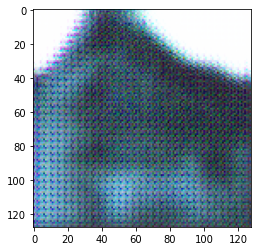

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

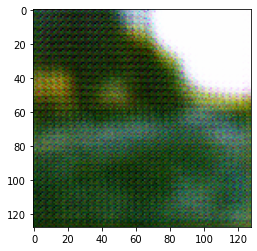

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

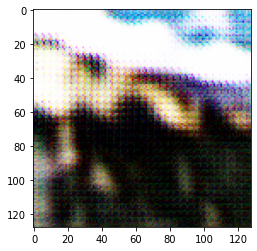

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

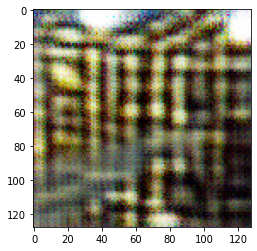

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

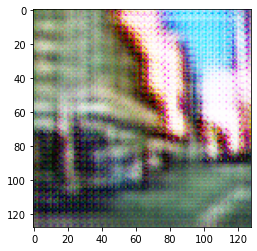

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

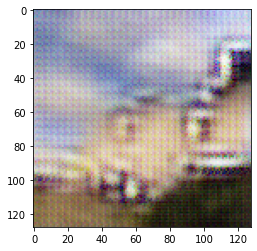

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

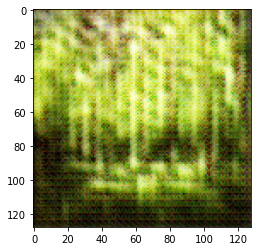

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

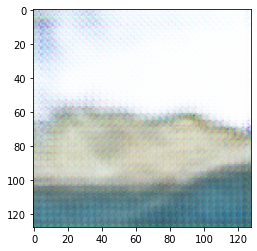

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([16, 3, 128, 128])
2
torch.Size([16, 1, 19, 19])
torch.Size([16, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

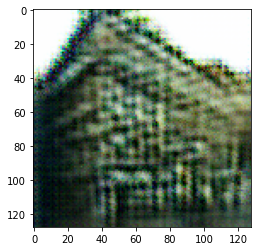

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

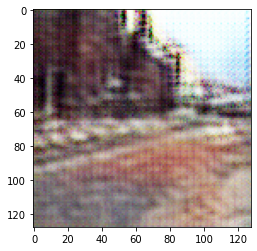

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

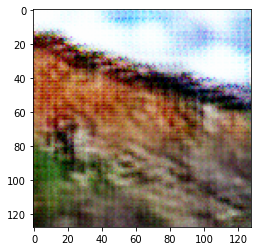

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

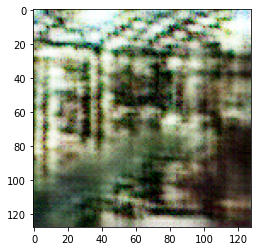

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

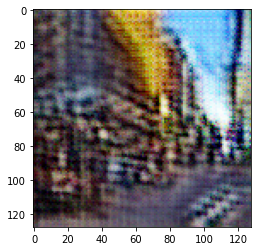

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

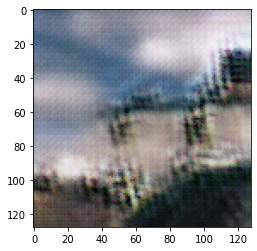

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

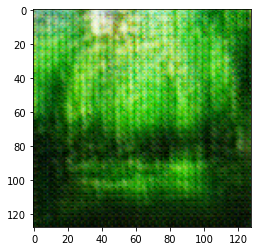

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

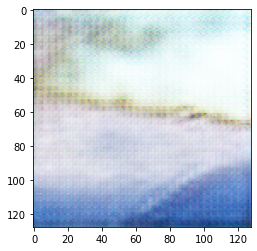

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([16, 3, 128, 128])
2
torch.Size([16, 1, 19, 19])
torch.Size([16, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

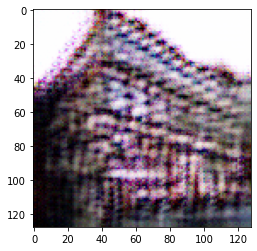

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

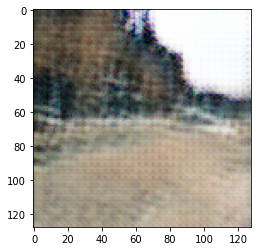

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

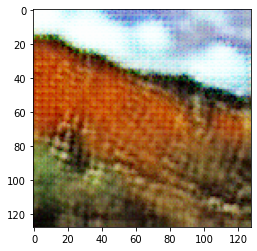

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

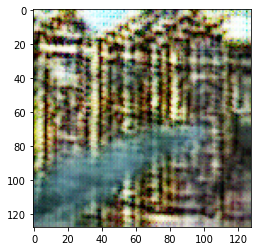

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

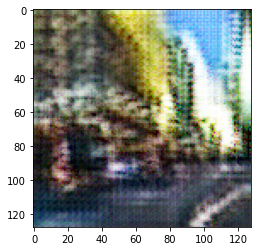

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

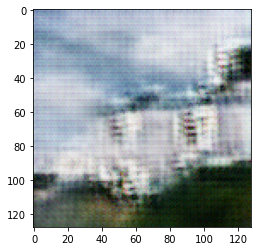

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

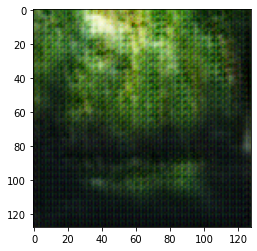

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

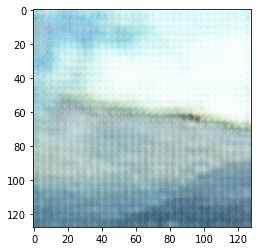

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([16, 3, 128, 128])
2
torch.Size([16, 1, 19, 19])
torch.Size([16, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

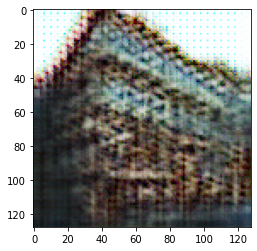

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

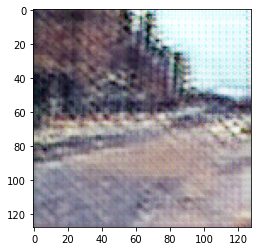

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

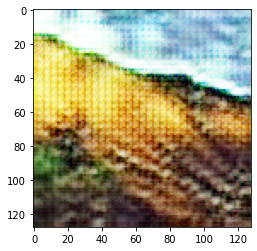

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

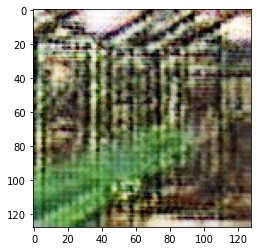

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

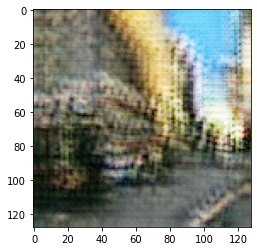

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

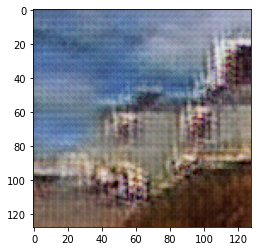

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

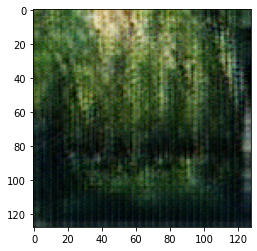

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

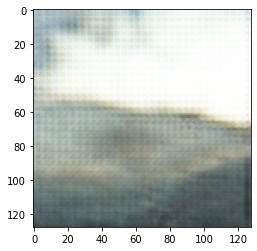

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([16, 3, 128, 128])
2
torch.Size([16, 1, 19, 19])
torch.Size([16, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

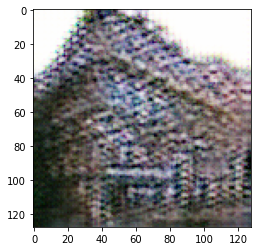

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

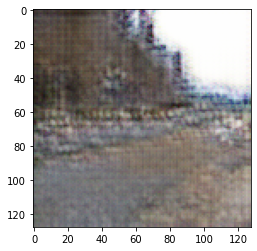

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

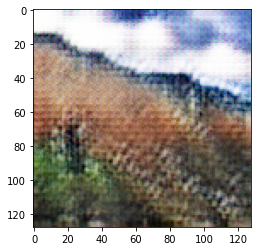

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

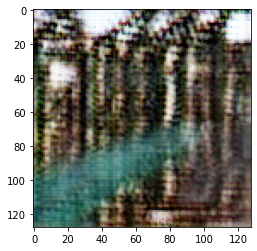

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

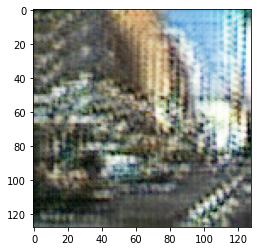

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

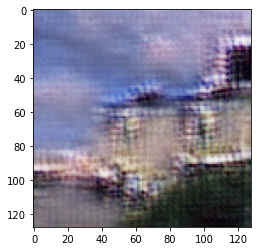

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

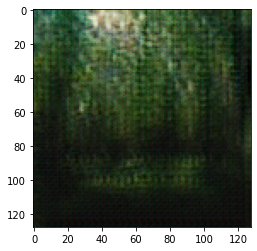

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

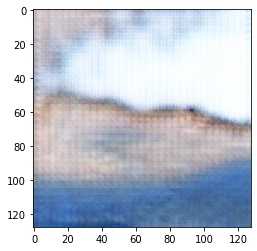

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([16, 3, 128, 128])
2
torch.Size([16, 1, 19, 19])
torch.Size([16, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

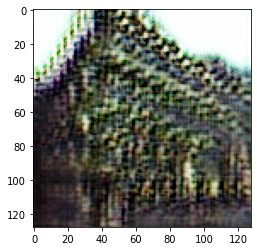

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

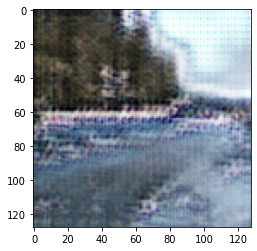

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

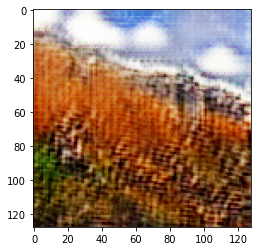

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

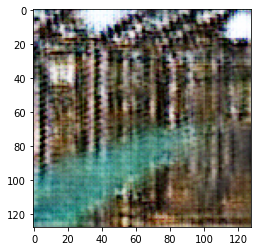

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

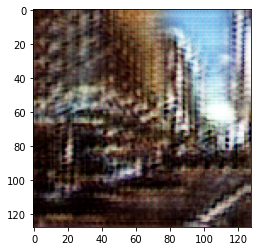

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

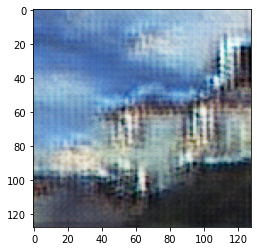

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

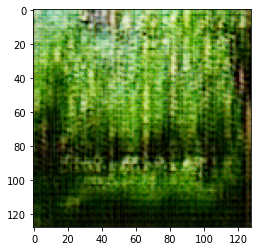

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

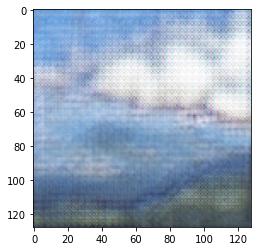

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([16, 3, 128, 128])
2
torch.Size([16, 1, 19, 19])
torch.Size([16, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

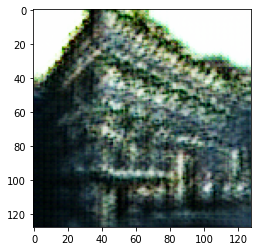

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

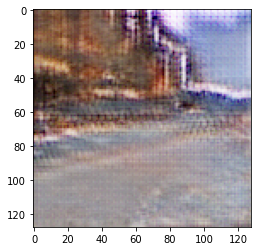

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

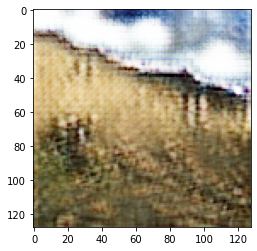

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

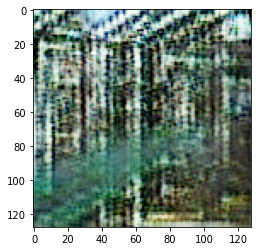

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

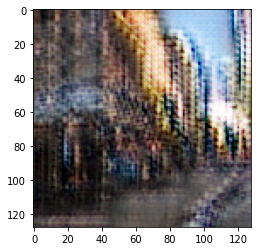

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

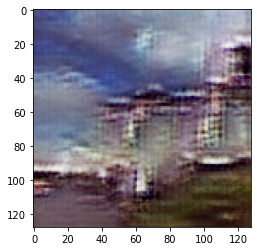

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

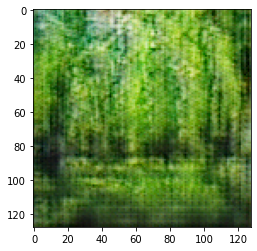

torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 19, 19])
2
2
torch.Size([32, 3, 128, 128])
2
torch.Size([32, 1, 19, 19])
torch.Size([32, 1, 1

In [ ]:
num_epochs = 10000
for epoch in range(1, num_epochs + 1):
    train(epoch)
    # if epoch % 10 == 0:
    #   save_checkpoint({
    #       'epoch': epoch + 1,
    #       'arch': Gener,
    #   })


